In [14]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [25]:
import torch
from data import KMeansMemorySetManager
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from kneed import KneeLocator

# Assuming the KMeansMemorySetManager is defined elsewhere and imported correctly
# from data import KMeansMemorySetManager

# Load the MNIST dataset with modifications to save in the current directory
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)

# Preprocess the dataset
x = train_dataset.data.view(-1, 784).float() / 255.0
y = train_dataset.targets.view(-1, 1)
num_samples, num_features = x.shape
num_classes = len(train_dataset.classes)

def find_optimal_k(x: torch.Tensor, max_centroids: int, random_seed: int) -> int:
    inertias = []
    for k in range(1, max_centroids + 1):
        kmeans = KMeans(n_clusters=k, random_state=random_seed).fit(x.cpu().numpy())
        inertias.append(kmeans.inertia_)

    kl = KneeLocator(range(1, max_centroids + 1), inertias, curve="convex", direction="decreasing")
    return kl.elbow

# Find the optimal number of centroids for each class using the elbow method
num_centroids_per_class = {}
max_centroids = 10  # Maximum number of centroids to consider for each class
random_seed = 42  # Random seed for reproducibility

for class_label in range(num_classes):
    class_mask = (y == class_label).squeeze()
    class_samples = x[class_mask]
    num_centroids_per_class[class_label] = find_optimal_k(class_samples, max_centroids, random_seed)



Memory Set Shape:
memory_x: torch.Size([12000, 784])
memory_y: torch.Size([12000])

Memory Set Samples per Class:
Class 0: 1200 samples
Class 1: 1200 samples
Class 2: 1200 samples
Class 3: 1200 samples
Class 4: 1200 samples
Class 5: 1200 samples
Class 6: 1200 samples
Class 7: 1200 samples
Class 8: 1200 samples
Class 9: 1200 samples

Optimal Number of Centroids per Class:
Class 0: 4 centroids
Class 1: 3 centroids
Class 2: 4 centroids
Class 3: 4 centroids
Class 4: 4 centroids
Class 5: 3 centroids
Class 6: 4 centroids
Class 7: 4 centroids
Class 8: 4 centroids
Class 9: 4 centroids

Retained Samples for Each Class (KMeansMemorySetManager):


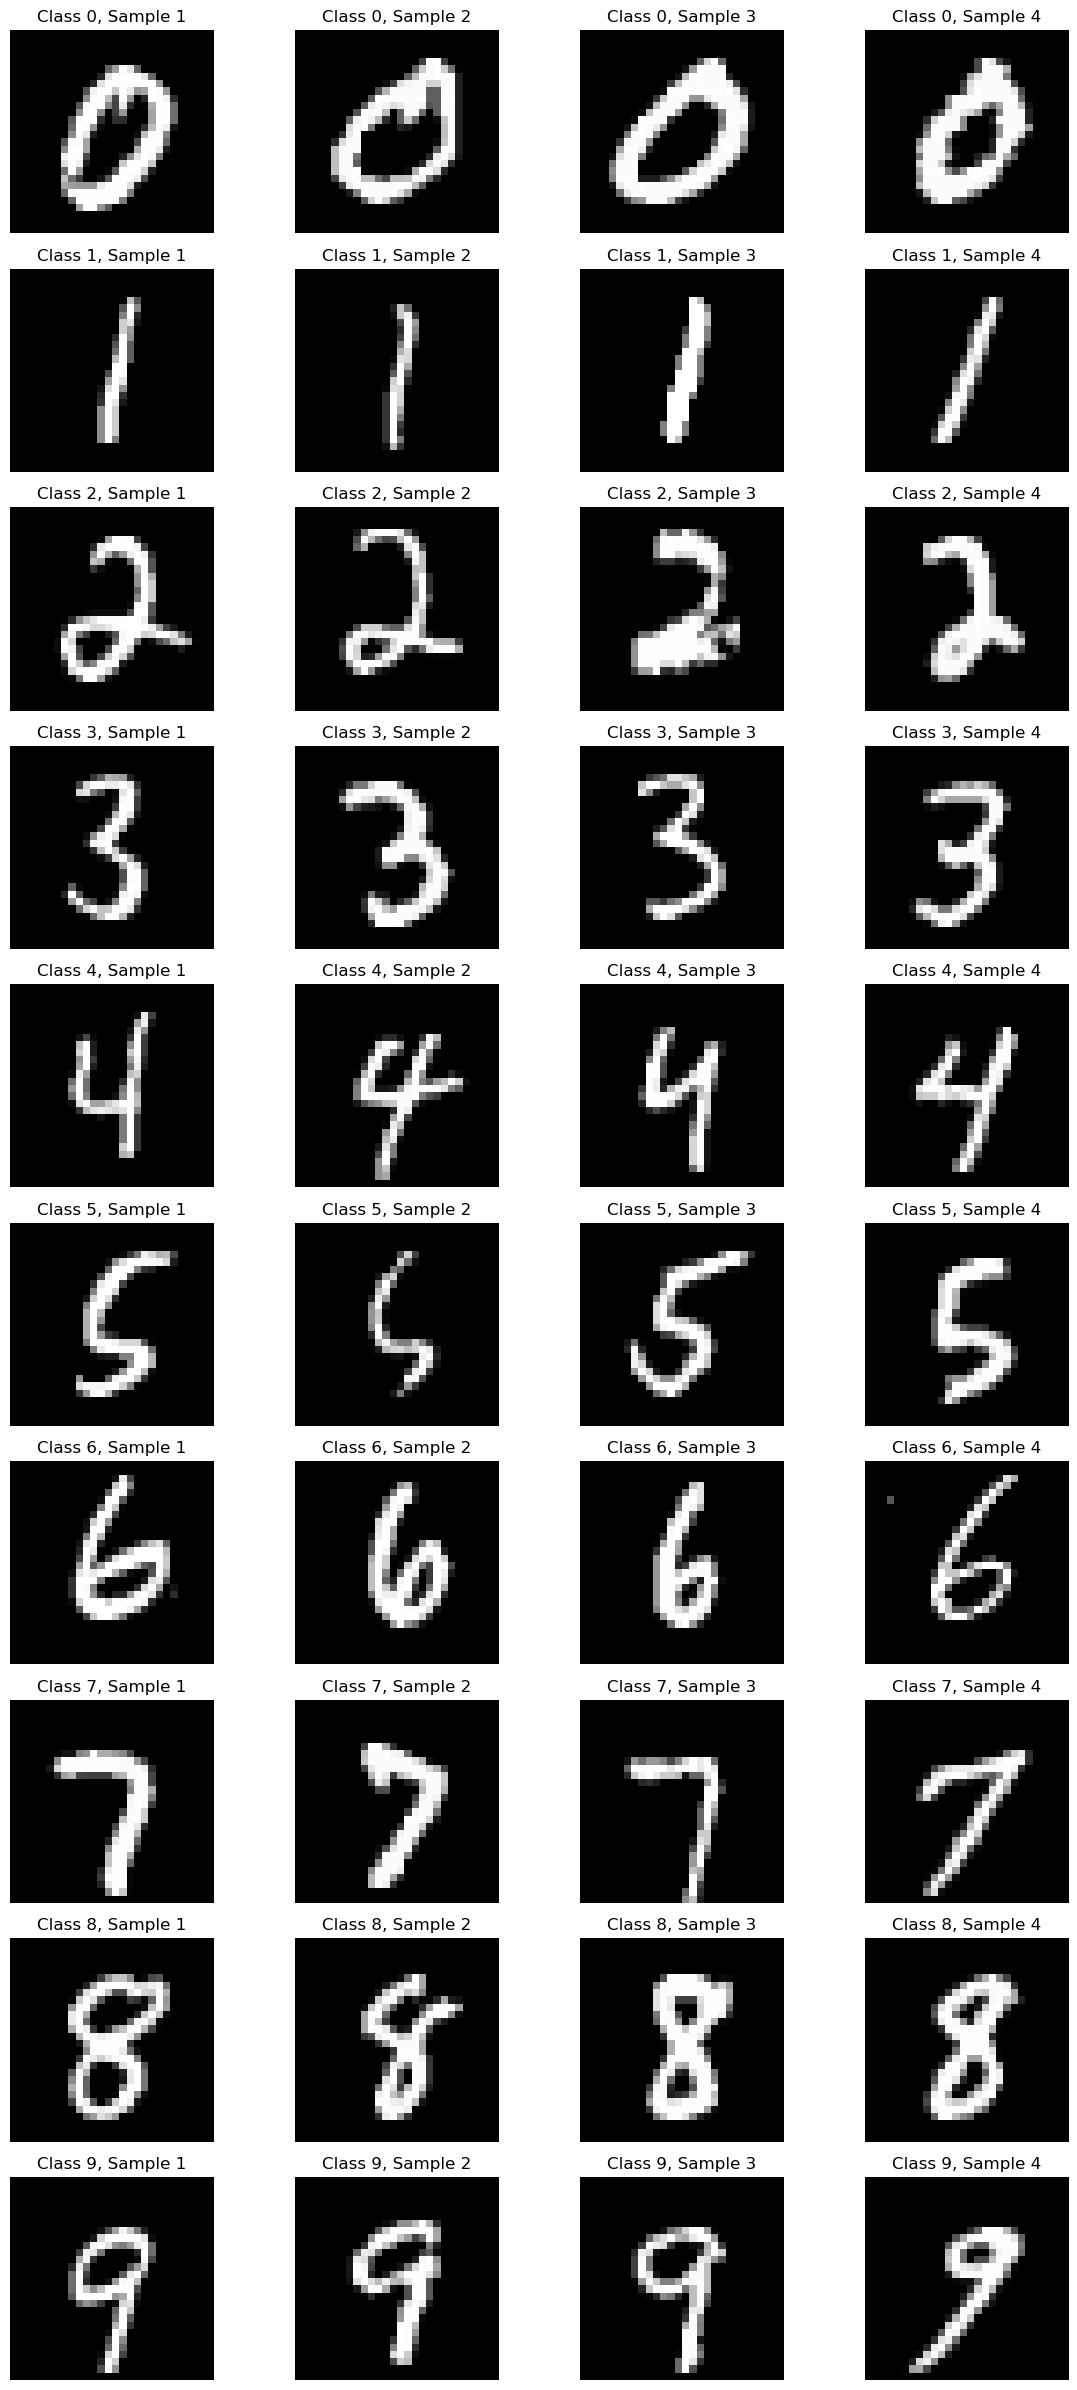

In [24]:
# Instantiate the KMeansMemorySetManager with adjusted parameters
memory_set_manager = KMeansMemorySetManager(
    p=0.2,  # 20% of samples in the memory set
    num_centroids=max(num_centroids_per_class.values()),  # Use the maximum number of centroids across all classes
    device=torch.device('cpu'),
    random_seed=random_seed
)

# Create the memory set
memory_x, memory_y = memory_set_manager.create_memory_set(x, y)

# Display the memory set shapes
print("Memory Set Shape:")
print("memory_x:", memory_x.shape)
print("memory_y:", memory_y.shape)

# Display the samples per class in the memory set
print("\nMemory Set Samples per Class:")
for class_label in range(num_classes):
    class_count = (memory_y == class_label).sum().item()
    print(f"Class {class_label}: {class_count} samples")

# Print the optimal number of centroids for each class
print("\nOptimal Number of Centroids per Class:")
for class_label in range(num_classes):
    num_centroids = num_centroids_per_class[class_label]
    print(f"Class {class_label}: {num_centroids} centroids")

# Visualize retained samples for each class
print("\nRetained Samples for Each Class (KMeansMemorySetManager):")
fig, axs = plt.subplots(num_classes, memory_set_manager.num_centroids, figsize=(12, 24))
for class_label in range(num_classes):
    class_indices = (memory_y == class_label).nonzero(as_tuple=True)[0]
    class_samples = memory_x[class_indices]
    for i in range(memory_set_manager.num_centroids):
        if i < len(class_samples):
            ax = axs[class_label, i]
            ax.imshow(class_samples[i].view(28, 28).numpy(), cmap='gray')
            ax.axis('off')
            ax.set_title(f"Class {class_label}, Sample {i+1}")
        else:
            ax = axs[class_label, i]
            ax.axis('off')
plt.tight_layout()
plt.show()